**author: Xiaowu He. horace_hxw_cal@berkeley.edu**

# Multi-label Classification Note
## 1. ECOC(multi-class setting)
#### step 1: map the class to the coresponding **binary** vector $[1,0,...,1]^T$ using the error correction codes.:
- Exhaustive code
- Col Selection from Exhaustive code (Hill Climbing)
- Randomize Hill Climbing
- BCH code

#### step 2: use maching learning algorithms to create the probability vector of each position to be 1.
- Decision Tree
- Nueral Network
- **create muliple binary classifiers for each position**

#### step 3： recover the origin class vector according to the cloest $\ell_1$ distance

## 2. MLGT (Group Testing)
The basic idea is to form group of labels and test each data point whether or not inside that group.
1. Construct  a specific binary matrix $A_{m\times d}$ and compress the original binary-label vector by $z = A \quad or \quad  y$ using matrix boolean opration. Then train the classifiers based on vector z.
2. Predicting process is to set the position $l$ of group vector to 1 iff $|supp(A^{(l)}) - supp(\hat{z}))| < \frac{e}{2}$. where the supp() means the set of indexees of nonzero enties in a given vector.

## 3. Haffman Tree Based multi-class Classification
constructing a haffman tree based on the frequency of each label. and train a binary classifier at each node of the tree.

**this can reduce the average classification and training time.**

## 4. ECOC in Multi-label setting
Assume there are m labels in total and each data point has no more than k labels.
1. we can map each label into a binary representation and concat them into a binary vector of leangth $k\log m$. If some data point doesn't have enough labels, add a default number to maintain the length.
2. Add **parity check**`    ` to the above vector using Error Correction Code
2. Train binary classifier on each digit.


# Implement ECOC in Multi-label Classification
## Set up
we are given a set of labeled trianing data $\{(x_i,y_i)\}_{i=1}^{n}$, where $x_i \in \mathbb{R}^p$ are the input features and $y_i \in \{0,1\}^d$ are vectors indicating the labels of each data point.

In practice, the label vector $y_i$ are sparse. We assume that the labels are at most k-sparse. And want to compress the label vectors into $k \cdot \log m$ length by concating the binary representation of each label index into a binary vector.

In [1]:
!ls

data_clean.py  data_util.pyc		      LDPC
data_clean.sh  ECOC_Multi-label-Eurlex.ipynb  LDPC.ipynb
data_util.py   ECOC_Multi-label.ipynb	      Untitled.ipynb


In [2]:
%matplotlib inline
import data_util
import matplotlib.pyplot as plt
import numpy as np
from data_util import DataPoint
import math
from LDPC.LDPCGenerator import LDPCCoder
import os

In [3]:
!ls -Ra ../data

../data:
.  ..  AmazonCat  Bibtex  Delicious  Eurlex  Mediamill	RCV1-x	Wiki10

../data/AmazonCat:
.  ..  amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
.  ..  Bibtex_data.txt	bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
.  ..  Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
.  ..  eurlex_test.txt	eurlex_train.txt

../data/Mediamill:
.  ..  Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
.  ..  rcv1x_test.txt  rcv1x_train.txt

../data/Wiki10:
.  ..  wiki10_test.txt	wiki10_train.txt


In [4]:
data_dir = "../data"
model_dir = "../.model"
filename = "/Eurlex/eurlex_train.txt"

path = os.path.dirname(filename)
model_path = model_dir + path

In [5]:
data, num_point, num_feature, num_label = data_util.read_file(data_dir+filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=15539, num_label=3993, num_feature=5000


## Step 1: Calculate the distribution of number of labels in each data point
if the maximum number k is relatively small, set the length of our label vector into $k\cdot \left \lceil {\log m} \right \rceil$

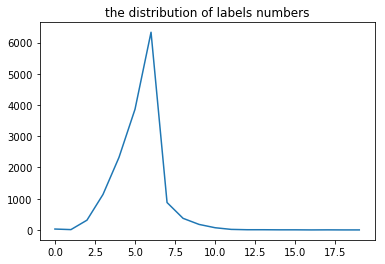

In [6]:
# find the distribution of num of labels in each data point
label_lengths = [0 for _ in range(num_label + 1)]
for data_point in data:
    label_lengths[len(data_point.labels)] += 1
plt.plot(label_lengths[:20])
plt.title("the distribution of labels numbers")

(15539, 15539)


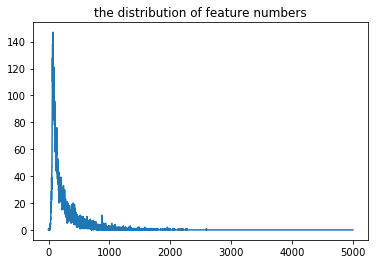

In [7]:
# find the distribution of num of features in each data point
feature_lengths = [0 for _ in range(num_feature + 1)]
for data_point in data:
    feature_lengths[len(data_point.features)] += 1
plt.plot(feature_lengths[:5000])
plt.title("the distribution of feature numbers")
print(sum(label_lengths), sum(feature_lengths))

In [8]:
# find the 99% value over a population
def find_percent(data, population, percent=0.99):
    target = population*(1-percent)
    for i in range(len(data)):
        population -= data[i]
        if population <= target:
            return i

label_k = find_percent(label_lengths, num_point)
print("99% of data points has less than {} labels and less than {} features"\
      .format(label_k, find_percent(feature_lengths, num_point)))

99% of data points has less than 9 labels and less than 1205 features


length = 5001


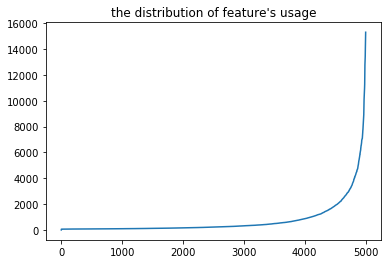

In [9]:
# find the distribution of usage of each feature
feature_nums = [0 for _ in range(num_feature + 1)]
print ("length = {}".format(len(feature_nums)))
for data_point in data:
    for feature in data_point.features:
        try:
            feature_nums[feature] += 1
        except IndexError:
            print feature
plt.plot(sorted(feature_nums))
plt.title("the distribution of feature's usage")

### Prominent Features
Because there're too many features to train, we choose to use only prominent features (features which were used by more than $\frac{1}{5}$ of data points). This is slightly different from the MLGT paper because we don't have enough computing power.

In [10]:
# find all prominent features
prominent_feature = set()
prominent_frac = 0.5
for feature in range(len(feature_nums)):
    if feature_nums[feature] >= num_point * prominent_frac:
        prominent_feature.add(feature)
print ("prominent featre num: {}".format(len(prominent_feature)))

prominent featre num: 45


In [11]:
# remove non-prominent features
for data_point in data:
    new_feature = {}
    for feature in data_point.features:
        if feature in prominent_feature:
            new_feature[feature] = data_point.features[feature]
    data_point.features = new_feature

In [12]:
# clear useless data for memory
feature_num = 0
feature_lengths = 0
label_lengths = 0

The above information might be useful for furthur optimize the parameters.

## Step 2: Generator Label vectors
The training and predicting process can be viewed as a channel transmition during a binary symetric channel. We first do source encoding to compress the labels information and then do channel encoding to ad the parity check to resist the channel error.
### 2.1 Source Encoding: create the compressed lable vec
For each data point's label, we first translate its labels into binary form and then concat them one by one in ascent order. the default value for the label vector would be "111..1".


In [13]:
def num_to_bin(x, length=None):
    '''
    convert a single lable to corresponding binary vector
    '''
    if length == None:
        length=int(math.log(x)/math.log(2)) + 1
    bits = [0]*length
    i = 0
    while x:
        bits[i] = x%2
        x >>= 1
        i+=1
    return bits

def bin_to_num(vec):
    pow2 = 1
    num = 0
    for x in vec:
        num += x*pow2
        pow2*=2
    return num

def l_to_vec(labels, k, length):
    '''
    compress the lable vector.
    input:
        k: maximum non-zero entries of lable in a data point
        length: length of each binary bevtor for a label
    '''
    labels.sort() #ascending order
    default_place = [1]*length
    vec = []
    for i in range(k):
        if i < len(labels):
            vec.extend(num_to_bin(labels[i], length))
        else:
            vec.extend(default_place)
    return (np.array(vec))

def vec_to_l(vec, length):
    default = 2**length - 1
    labels = []
    for i in range(0, len(vec), length):
        num = bin_to_num(vec[i:i+length])
        if num != default:
            labels.append(num)
    return labels

In [14]:
bin_to_num(num_to_bin(100))

100

In [15]:
vec_to_l(l_to_vec([1,2,3], 14, 5),5)

[1, 2, 3]

In [16]:
ms_length = int(math.log(num_label)/math.log(2)) + 1
Y_tr_true = [l_to_vec(data_point.labels, label_k, ms_length) for data_point in data]

In [17]:
len(Y_tr_true[0])

108

### 2.2 Channel Encoding: Add parity check to label vector
we apply the traditional error correcting codes to the label vector to get a fixed length new output vector.

Here, we use the LDPC(Low-density parity-check code) to encode the  compessed label vectors.

The details of LDPC can be seen [here](https://en.wikipedia.org/wiki/Low-density_parity-check_code)

the LDPCCoder class is like this:
```Python
    >> ldpc = LDPCCoder(10)
    >> received_codeword = ldpc.encode([0,0,0,1,0,1,1,1,1,1])
    >> for i in xrange(len(received_codeword)):
    ....   if np.random.rand() > 0.95:
    ....   received_codeword[i] = 1 - received_codeword[i]
    >> ldpc.decode(received_codeword)
    array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1])
```

In [18]:
n = 20 # we can translate 10 bits.
ldpc = LDPCCoder(n, flip_p=0.1)
print("message length = {}, code_word length ={}".format(ldpc.bits, ldpc.code_length))

message length = 20, code_word length =42


In [19]:
Y_tr = np.array([ldpc.encode(label_vec) for label_vec in Y_tr_true])

In [20]:
Y_tr.shape

(15539, 252)

## Step3: train the classifiers
train binary classifers for each of the input (X_tr,Y_tr[i,:]) data.

Over the transformed vector, train a binary classifier for each of them is just use the one vs rest multi-class algorithm. Here we choose the LogisticRegression algorithm in sklearn.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import os

In [22]:
# map features to corresponding position
prominent_feature = list(prominent_feature)
feature_to_id = {}
for n, feature in enumerate(prominent_feature):
    feature_to_id[feature] = n

In [23]:
def feature_to_bin(features, _feature_num):
    vec = np.zeros(_feature_num)
    for key in features:
        vec[feature_to_id[key]] = features[key]
    return vec

In [24]:
X_tr = np.array([feature_to_bin(data_point.features, len(prominent_feature)) for data_point in data])
X_tr.shape

(15539, 45)

In [25]:
# normalize the data
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_tr.shape

(15539, 45)

In [26]:
X_tr, Y_tr = shuffle(X_tr, Y_tr, random_state=0)

In [27]:
class fake_classifer(): #handle the case that all data in the same class...
    def __init__(self, x):
        self.x = x
        
    def predict(self, X):
        pred = np.ones(X.shape[0], dtype=np.int)
        return pred*self.x


In [111]:

for i in range(len(Y_tr[0])):
    print "Trianning model for the {}th bit\n... ... ... ".format(i)
    #clf = SVC()
    clf = LogisticRegression()
    try: 
        clf.fit(X=X_tr, y=Y_tr[:,i])
    except ValueError:
        print i, Y_tr[:,i]
        if Y_tr[:, i].sum() == 0: #all classes are 0
            clf = fake_classifer(0)
        elif Y_tr[:, i].sum() == len(Y_tr[:, i]):
            clf = fake_classifer(1)
            
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(i)))
    print "Model for {}th bit successfully stored in {}/label{}.pkl\n".format(i, model_path, i)


Trianning model for the 0th bit
... ... ... 
Model for 0th bit successfully stored in ../.model/Eurlex/label0.pkl

Trianning model for the 1th bit
... ... ... 
Model for 1th bit successfully stored in ../.model/Eurlex/label1.pkl

Trianning model for the 2th bit
... ... ... 
Model for 2th bit successfully stored in ../.model/Eurlex/label2.pkl

Trianning model for the 3th bit
... ... ... 
Model for 3th bit successfully stored in ../.model/Eurlex/label3.pkl

Trianning model for the 4th bit
... ... ... 
Model for 4th bit successfully stored in ../.model/Eurlex/label4.pkl

Trianning model for the 5th bit
... ... ... 
Model for 5th bit successfully stored in ../.model/Eurlex/label5.pkl

Trianning model for the 6th bit
... ... ... 
Model for 6th bit successfully stored in ../.model/Eurlex/label6.pkl

Trianning model for the 7th bit
... ... ... 
Model for 7th bit successfully stored in ../.model/Eurlex/label7.pkl

Trianning model for the 8th bit
... ... ... 
Model for 8th bit successfully stor

Model for 70th bit successfully stored in ../.model/Eurlex/label70.pkl

Trianning model for the 71th bit
... ... ... 
Model for 71th bit successfully stored in ../.model/Eurlex/label71.pkl

Trianning model for the 72th bit
... ... ... 
Model for 72th bit successfully stored in ../.model/Eurlex/label72.pkl

Trianning model for the 73th bit
... ... ... 
Model for 73th bit successfully stored in ../.model/Eurlex/label73.pkl

Trianning model for the 74th bit
... ... ... 
Model for 74th bit successfully stored in ../.model/Eurlex/label74.pkl

Trianning model for the 75th bit
... ... ... 
Model for 75th bit successfully stored in ../.model/Eurlex/label75.pkl

Trianning model for the 76th bit
... ... ... 
Model for 76th bit successfully stored in ../.model/Eurlex/label76.pkl

Trianning model for the 77th bit
... ... ... 
Model for 77th bit successfully stored in ../.model/Eurlex/label77.pkl

Trianning model for the 78th bit
... ... ... 
Model for 78th bit successfully stored in ../.model/Eurl

Model for 139th bit successfully stored in ../.model/Eurlex/label139.pkl

Trianning model for the 140th bit
... ... ... 
Model for 140th bit successfully stored in ../.model/Eurlex/label140.pkl

Trianning model for the 141th bit
... ... ... 
Model for 141th bit successfully stored in ../.model/Eurlex/label141.pkl

Trianning model for the 142th bit
... ... ... 
Model for 142th bit successfully stored in ../.model/Eurlex/label142.pkl

Trianning model for the 143th bit
... ... ... 
Model for 143th bit successfully stored in ../.model/Eurlex/label143.pkl

Trianning model for the 144th bit
... ... ... 
Model for 144th bit successfully stored in ../.model/Eurlex/label144.pkl

Trianning model for the 145th bit
... ... ... 
Model for 145th bit successfully stored in ../.model/Eurlex/label145.pkl

Trianning model for the 146th bit
... ... ... 
Model for 146th bit successfully stored in ../.model/Eurlex/label146.pkl

Trianning model for the 147th bit
... ... ... 
Model for 147th bit successfully

Model for 210th bit successfully stored in ../.model/Eurlex/label210.pkl

Trianning model for the 211th bit
... ... ... 
211 [0 0 0 ..., 0 0 0]
Model for 211th bit successfully stored in ../.model/Eurlex/label211.pkl

Trianning model for the 212th bit
... ... ... 
Model for 212th bit successfully stored in ../.model/Eurlex/label212.pkl

Trianning model for the 213th bit
... ... ... 
Model for 213th bit successfully stored in ../.model/Eurlex/label213.pkl

Trianning model for the 214th bit
... ... ... 
Model for 214th bit successfully stored in ../.model/Eurlex/label214.pkl

Trianning model for the 215th bit
... ... ... 
215 [0 0 0 ..., 0 0 0]
Model for 215th bit successfully stored in ../.model/Eurlex/label215.pkl

Trianning model for the 216th bit
... ... ... 
Model for 216th bit successfully stored in ../.model/Eurlex/label216.pkl

Trianning model for the 217th bit
... ... ... 
Model for 217th bit successfully stored in ../.model/Eurlex/label217.pkl

Trianning model for the 218th bit

In [28]:
clf = joblib.load(os.path.join(model_path , 'label{}.pkl'.format(0)))
clf.predict(X_tr[1000].reshape(1,-1))

array([0])

## Step 4: Validate the Model
We use $Precision@k$ to be our model evaluation metics. 

The definition can be found here: [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)



In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [30]:
classifiers = [] # there will be len(Y_tr[0]) binary classifiers
for i in range(len(Y_tr[0])):
    classifiers.append(joblib.load(os.path.join(model_path , 'label{}.pkl'.format(i))))

In [31]:
classifiers[23].predict(X_tr)

array([0, 0, 1, ..., 0, 0, 0])

In [32]:
def predict_all(clfs, X):
    '''
    input the features and output the original label vector
    '''
    # step 1, predict each bit of the encoded label
    y_pred = np.array([clf.predict(X) for clf in clfs])
    # step 2, resize every bit to coressponding label
    y_pred = y_pred.T # transpose is enough
    #print y_pred
    # step 3, decode
    y_pred = [ldpc.decode(y_point) for y_point in y_pred]
    return y_pred
    

In [33]:
y_pred = np.array([clf.predict(X_tr) for clf in classifiers])

In [34]:
y_pred = predict_all(classifiers, X_tr)

In [35]:
y_pred = [y_point[0:len(Y_tr_true[0])] for y_point in y_pred]

In [36]:
y_pred = [vec_to_l(y_point, ms_length) for y_point in y_pred]

In [39]:
def label_to_bin(labels, _label_num):
    vec = np.zeros(_label_num)
    for label in labels:
        if label > _label_num:
            continue
        vec[label-1] = 1
    return vec

In [40]:
y_pred_bin = np.array([label_to_bin(y, num_label) for y in y_pred])

In [41]:
y_true_bin = np.array([label_to_bin(y, num_label) for y in Y_tr_true])

In [42]:
precision_score(y_true_bin, y_pred_bin, average='samples')

0.00025116016331667274

In [43]:
accuracy_score(y_true_bin, y_pred_bin)

0.0

In [46]:
sumt = 0
sumf = 0
for i in range(y_pred_bin.shape[0]):
    for j in range(y_pred_bin.shape[1]):
        if y_pred_bin[i, j] == y_true_bin[i, j] and y_true_bin[i, j]==1:
            sumt+=1
        elif y_true_bin[i, j] == 1:
            sumf+=1
sumt, sumf

(35, 31015)